In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('data\SMSSpamCollection_cleaned.csv')

In [3]:
df.head()

,message,flag
0,go jurong point crazy Available bugis n great ...,ham
1,ok lar joke wif u oni,ham
2,free entry wkly comp win FA Cup final tkts st ...,spam
3,U dun say early hor u c already say,ham
4,nah do nt think go usf live around though,ham


In [4]:
# convert flag column into dummy variable
df = pd.get_dummies(df, columns=['flag'], drop_first=True)

df.head()

,message,flag_spam
0,go jurong point crazy Available bugis n great ...,0
1,ok lar joke wif u oni,0
2,free entry wkly comp win FA Cup final tkts st ...,1
3,U dun say early hor u c already say,0
4,nah do nt think go usf live around though,0


In [5]:
df.isnull().sum()

message      4
flag_spam    0
dtype: int64

There are empty messages in the dataset so we need to drop the rows.

In [6]:
df.dropna(inplace=True)

df.isnull().sum()

message      0
flag_spam    0
dtype: int64

In [7]:
df_spam = df[df['flag_spam'] == 1]
df_spam.shape

(613, 2)

In [8]:
df_not_spam = df[df['flag_spam'] == 0]
df_not_spam.shape

(4495, 2)

We need to convert messages into vectors using CountVectorizer, with each vector containing an array of token counts.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Create vectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit(df['message'])

X_transform = X.transform(df['message'])

print(X_transform)

  (0, 216)	1
  (0, 404)	1
  (0, 799)	1
  (0, 801)	1
  (0, 1066)	1
  (0, 1303)	1
  (0, 2350)	1
  (0, 2397)	1
  (0, 2479)	1
  (0, 3170)	1
  (0, 3304)	1
  (0, 4660)	1
  (0, 6788)	1
  (0, 7004)	1
  (1, 3133)	1
  (1, 3333)	1
  (1, 4267)	1
  (1, 4300)	1
  (1, 6909)	1
  (2, 298)	1
  (2, 1161)	1
  (2, 1350)	1
  (2, 1864)	2
  (2, 1979)	2
  (2, 2079)	1
  :	:
  (5106, 828)	1
  (5106, 1561)	1
  (5106, 1817)	1
  (5106, 2168)	1
  (5106, 2206)	1
  (5106, 2314)	1
  (5106, 2535)	1
  (5106, 2620)	1
  (5106, 2865)	1
  (5106, 2918)	1
  (5106, 2987)	1
  (5106, 3037)	1
  (5106, 3425)	1
  (5106, 4082)	1
  (5106, 5657)	1
  (5106, 5666)	1
  (5106, 6192)	1
  (5106, 6315)	1
  (5106, 6615)	1
  (5106, 6834)	1
  (5107, 3054)	2
  (5107, 4012)	1
  (5107, 5173)	1
  (5107, 6315)	1
  (5107, 6437)	1


After applying CountVectorizer, we will use TF-IDF to find out how relevant a word is to each message in the dataset. 

The value of TF-IDF increases proportionally to the number of times a word appears in the message, and is offset by the frequency of the word in the collection.

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(X_transform)

In [11]:
# transform entire bag of words corpus into TF-IDF corpus
X_tfidf = tfidf_transformer.transform(X_transform)
print(X_tfidf.shape)

(5108, 7234)


Now we have transformed our messages into vectors, we can start training our classifier.

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1355
           1       0.33      0.01      0.01       178

    accuracy                           0.88      1533
   macro avg       0.61      0.50      0.47      1533
weighted avg       0.82      0.88      0.83      1533

Accuracy = 0.88
Recall = 0.01
Precision = 0.33


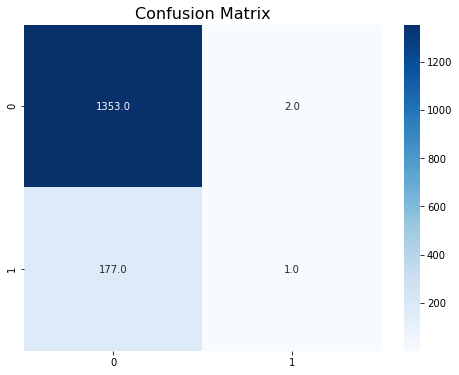

In [42]:
# train-test split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df['flag_spam'], test_size=0.3, random_state=42
)

#Train
svc = SVC(kernel='linear').fit(X_train, y_train)
preds = svc.predict(X_test)

#Evaluate
print (classification_report(y_test, predictions))
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\nPrecision = {precision_score(y_test, preds):.2f}' )
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f');

As we can see, the model correctly identify all 'ham' messages, but 